# 2.2 En este notebook exploraremos estrategias para optimizar los mecanismos de DP utilizados sobre el set de datos que contiene los registros de causas de violencia de género (set de datos I). 

In [ ]:
!pip install diffprivlib

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from scipy import stats
import diffprivlib as dp
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    q= np.where(q == 0, 0.000000001, q)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

In [ ]:
###Conecto al drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
###Cargo Dataset procesado 
ds = pd.read_csv('/content/gdrive/MyDrive/dataset_vio_gen_pro.csv', index_col=0)

In [ ]:
ds.shape

(795, 16)

In [ ]:
ds.head()

,CONDUCTA,GENERO_ACUSADO/A,NACIONALIDAD_ACUSADO/A,EDAD_ACUSADO/A AL MOMENTO DEL HECHO,NIVEL_INSTRUCCION_ACUSADO/A,GENERO_DENUNCIANTE,NACIONALIDAD_DENUNCIANTE,EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO,FRECUENCIA_EPISODIOS,RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE,HIJOS_HIJAS_EN_COMUN,MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO,TIPO_DE_RESOLUCION,OBJETO_DE_LA_RESOLUCION,DECISION,LEY_Y_ARTICULO,MODALIDAD_Y_LUGAR_HECHO
NRO_REGISTRO,,,,,,,,,,,,,,,,,
0710bis,otros,varon,argentina,s/d,s/d,mujer,argentina,s/d,primera_vez,ex_pareja,no,no,interlocutoria,medida_probatoria,no_hace_lugar,otros,otros
0715,otros,varon,otros,s/d,s/d,mujer,otros,s/d,habitual,otros,no,no,interlocutoria,medida_probatoria,no_hace_lugar,otros,otros
0716,amenazas,varon,paraguaya,entre_40_50,sin_instruccion,mujer,peruana,entre_30_40,habitual,ex_pareja,si,no,definitiva,otros,hace_lugar,codigo_penal_de_la_nacion / 149bis,domestica / en_domicilio_particular
0719,hostigamiento,varon,argentina,entre_30_40,secundario_completo,mujer,argentina,entre_30_40,primera_vez,ex_pareja,si,no,interlocutoria,otros,no_hace_lugar,codigo_contravencional / 52,otros
0745,amenazas,varon,argentina,entre_40_50,primario_completo,mujer,argentina,s/d,habitual,ex_pareja,si,no,definitiva,suspension_del_proceso_a_prueba,hace_lugar,codigo_penal_de_la_nacion / 149bis,domestica / en_domicilio_particular


## 2.2.1 Tratamiento de inconsistencias en las salidas de DP







Un punto que no ha sido considerado aún es la posible inconsistencia de una tabla de distribución de frecuencias resultante de un mecanismo de DP. Como los mecanismos de DP agregan ruido tomado de variables aleatorias independientes e idénticamente distribuidas (IID) a cada punto de la salida, es decir, al conteo o probabilidad de cada categoría de una variable, es posible que su salida no sea consistente.

Una posibilidad es que las probabilidades para alguna categoría de una variable sean negativas. Ante este evento, debe restaurarse la consistencia de la tabla de distribución de frecuencias generada.

En ese caso, se pueden seguir varios enfoques. Una posibilidad es truncar el dominio de la distribución de la que el mecanismo toma el ruido. Así, podemos asegurarnos que los valores van a quedar dentro de cierto rango. Si algún valor cae por fuera de este rango, el mismo es reemplazado por el extremo del rango más cercano. Otra posibilidad es llevar todas las probabilidades negativas a 0, y distribuir (sustrayendo) proporcionalmente esta densidad de probabilidad de las categorías con probabilidad positiva.

La librería que estamos utilizando permite realizar ambos tipos de imputación de la probabilidad negativa. A continuación compararemos ambas estrategias, a ver cuál nos brinda mejores resultados.


In [ ]:
mech = ['lap', 'laptrunc']
budgets = [0.5,1,2,3,4,5,6,7]
error_budget = []

for b in budgets: 

  error_mech = []
  epsilon = b/len(ds.columns)

  for m in mech:

    if m == 'gauss':
      sens = np.sqrt(len(ds.columns))
      delta = 0.0005
    else:
      sens = len(ds.columns)
      delta = 0

    divergencia_kl_budget_bin = []
    error_absoluto_budget_bin = []

    for i in range(0,1000):

      div_kl_hist = []
      error_abs_hist = []
      for (columnName, columnData) in ds.iteritems():
        
      
        codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
        n_cat = len(np.unique(codes))###Calculo la cantidad de bins que utilizará la función histograma, que será uno por categoría de la variable.

        ###CON DP
        dp_hist, dp_bins = dp.tools.histogram(codes, mech=m, epsilon=epsilon, delta=delta, sens=sens, bins=n_cat)

        ###Sin DP
        hist, bins = np.histogram(codes, bins=n_cat)
        hist = hist / hist.sum()

        ###Error
        div_kl_hist.append(kl(hist, dp_hist))
        error_abs_hist.append(np.abs(hist - dp_hist).sum())

      divergencia_kl_budget_bin.append(div_kl_hist)
      error_absoluto_budget_bin.append(error_abs_hist)

    divergencia_kl_budget_bin = np.mean(divergencia_kl_budget_bin, axis=0)
    error_absoluto_budget_bin = np.mean(error_absoluto_budget_bin, axis=0)

    error_mech.append([b, m, np.mean(divergencia_kl_budget_bin), np.mean(error_absoluto_budget_bin)])
  error_budget.append(pd.DataFrame(error_mech))

error_budget = pd.concat(error_budget)
error_budget.columns = ['Budget', 'Mecanismo', 'Divergencia KL', 'Error Absoluto']

In [ ]:
error_budget

,Budget,Mecanismo,Divergencia KL,Error Absoluto
0,0.5,lap,4.660449,0.979725
1,0.5,laptrunc,5.730188,0.908970
0,1.0,lap,3.302976,0.770222
1,1.0,laptrunc,3.672690,0.706637
0,2.0,lap,1.519092,0.493524
1,2.0,laptrunc,1.948275,0.475852
0,3.0,lap,0.908394,0.365331
1,3.0,laptrunc,1.225196,0.364405
0,4.0,lap,0.617325,0.292780
1,4.0,laptrunc,0.855308,0.293010


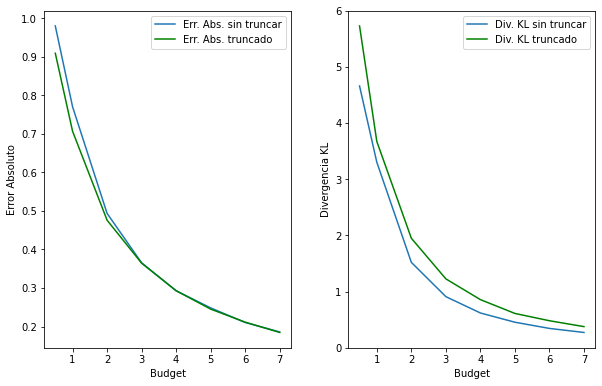

In [ ]:
error_lap = error_budget.loc[error_budget.Mecanismo == 'lap', :]
error_laptrunc = error_budget.loc[error_budget.Mecanismo == 'laptrunc', :]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (9, 6))

axs[0].plot(error_lap['Budget'], error_lap['Error Absoluto'])
axs[0].plot(error_lap['Budget'], error_laptrunc['Error Absoluto'], color='green')
axs[0].set_xlabel('Budget')
axs[0].set_ylabel('Error Absoluto')
axs[0].legend(['Err. Abs. sin truncar', 'Err. Abs. truncado'])

axs[1].plot(error_lap['Budget'], error_lap['Divergencia KL'])
axs[1].plot(error_lap['Budget'], error_laptrunc['Divergencia KL'], color='green')
axs[1].set_xlabel('Budget')
axs[1].set_ylabel('Divergencia KL')
axs[1].legend(['Div. KL sin truncar', 'Div. KL truncado'])

fig.tight_layout(pad=3.0)

###fig.suptitle('Error del mecanismo laplace en función del postprocesamiento', size = 25)


Lo que señala la evidencia es que el postprocesamiento sin truncado presenta mejores resultados medidos a través de la divergencia KL y resultados similares, medidos a través del error absoluto, en relación al postprocesamiento con truncado. Por este motivo, seguiremos utilizando esta estrategia.


## 2.2.2 Evaluación de los mecanismos de DP



Habiendo determinado el mejor criterio para el tratamiento de estas inconsistencias, veremos a continuación qué mecanismo de DP es que mejor performance tiene sobre este conjunto de datos. Para ello, evaluaremos la calidad de las salidas del mecanismo laplaciano y del gaussiano.

A continuación veremos cuál de estos mecanismos, dado cierto budget, permite garantizar DP deteriorando menos la salida de la información.



In [ ]:
mech = ['lap', 'gauss']
budgets = [0.5,1,2,3,4,5,6,7]
error_budget = []

for b in budgets: 

  error_mech = []
  epsilon = b/len(ds.columns)

  for m in mech:

    if m == 'gauss':
      sens = np.sqrt(len(ds.columns))
      delta = 0.0005
    else:
      sens = len(ds.columns)
      delta = 0

    divergencia_kl_budget_bin = []
    error_absoluto_budget_bin = []

    for i in range(0,1000):

      div_kl_hist = []
      error_abs_hist = []
      for (columnName, columnData) in ds.iteritems():
        
      
        codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
        n_cat = len(np.unique(codes))###Calculo la cantidad de bins que utilizará la función histograma, que será uno por categoría de la variable.

        ###CON DP
        dp_hist, dp_bins = dp.tools.histogram(codes, mech=m, epsilon=epsilon, delta=delta, sens=sens, bins=n_cat)

        ###Sin DP
        hist, bins = np.histogram(codes, bins=n_cat)
        hist = hist / hist.sum()

        ###Error
        div_kl_hist.append(kl(hist, dp_hist))
        error_abs_hist.append(np.abs(hist - dp_hist).sum())

      divergencia_kl_budget_bin.append(div_kl_hist)
      error_absoluto_budget_bin.append(error_abs_hist)

    divergencia_kl_budget_bin = np.mean(divergencia_kl_budget_bin, axis=0)
    error_absoluto_budget_bin = np.mean(error_absoluto_budget_bin, axis=0)

    error_mech.append([b, m, np.mean(divergencia_kl_budget_bin), np.mean(error_absoluto_budget_bin)])
  error_budget.append(pd.DataFrame(error_mech))

error_budget = pd.concat(error_budget)
error_budget.columns = ['Budget', 'Mecanismo', 'Divergencia KL', 'Error Absoluto']

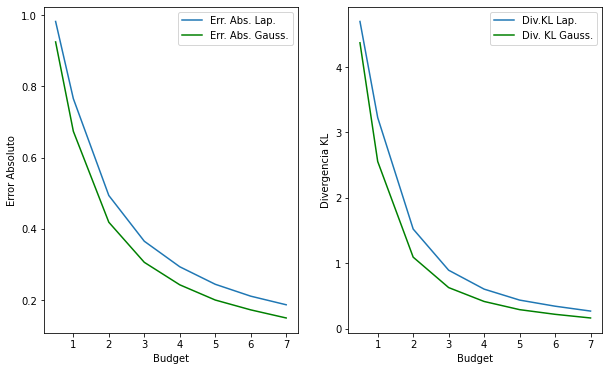

In [ ]:
error_lap = error_budget.loc[error_budget.Mecanismo == 'lap', :]
error_gauss = error_budget.loc[error_budget.Mecanismo == 'gauss', :]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10, 6))

axs[0].plot(error_lap['Budget'], error_lap['Error Absoluto'])
axs[0].plot(error_lap['Budget'], error_gauss['Error Absoluto'], color='green')
axs[0].set_xlabel('Budget')
axs[0].set_ylabel('Error Absoluto')
axs[0].legend(['Err. Abs. Lap.', 'Err. Abs. Gauss.'])

axs[1].plot(error_lap['Budget'], error_lap['Divergencia KL'])
axs[1].plot(error_lap['Budget'], error_gauss['Divergencia KL'], color='green')
axs[1].set_xlabel('Budget')
axs[1].set_ylabel('Divergencia KL')
axs[1].legend(['Div.KL Lap.', 'Div. KL Gauss.'])

###fig.suptitle('Error del mecanismo DP en función del budget asignado')



In [ ]:
error_budget.reset_index(drop=True)

,Budget,Mecanismo,Divergencia KL,Error Absoluto
0,0.5,lap,4.696936,0.981949
1,0.5,gauss,4.371245,0.924574
2,1.0,lap,3.227135,0.765233
3,1.0,gauss,2.556147,0.673612
4,2.0,lap,1.523102,0.493313
5,2.0,gauss,1.093168,0.418248
6,3.0,lap,0.893661,0.364914
7,3.0,gauss,0.628061,0.305717
8,4.0,lap,0.604455,0.293205
9,4.0,gauss,0.415739,0.242548


Lo que evidencian estos resultados es que en esta comparación el mecanismo gaussiano tiene dominancia sobre el laplaciano. Para todos los presupuestos, la calidad de la salida de este mecanismo es superior al mecanismo laplaciano ¿A qué se debe esta mejor performance? A priori, la explicación más sencilla podría ser que el mecanismo gaussiano está obteniendo ventaja de utilizar la sensibilidad L2. Veamos a continuación las respectivas distribuciones laplaciana y gaussiana de donde estos mecanismos estan tomando el ruido para terminar de comprobar lo que está sucediendo. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


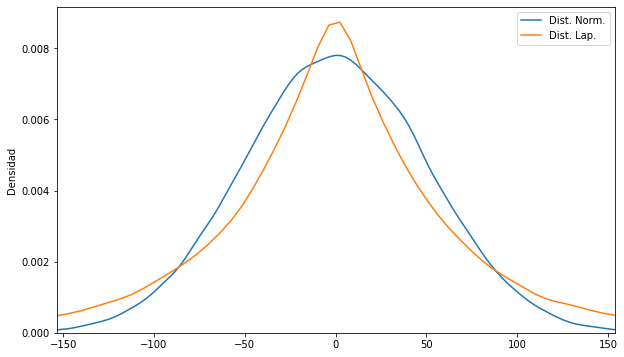

In [ ]:
delta = 0.0005
epsilon = 5/len(ds.columns)
sensL2 = np.sqrt(len(ds.columns))
escala_norm = np.sqrt(2 * np.log(1.25 / delta)) * sensL2 / epsilon
value_norm = np.random.normal(loc=0,scale=escala_norm,size=100000)
sensL1 = len(ds.columns)
escala_lap = sensL1 / epsilon
value_lap = np.random.laplace(loc=0,scale=escala_lap,size=100000)
plt.figure(figsize=(10, 6))
fig = sns.distplot(value_norm, hist = False)
sns.distplot(value_lap, hist = False)
fig.set_xlim([-escala_lap*3, escala_lap*3])
fig.set_ylabel('Densidad')
fig.legend(['Dist. Norm.', 'Dist. Lap.'])


Estas dos distribuciones se asemejan bastante. A pesar de que la distribución normal estándar es más “achatada” que la laplace estándar, en este caso ambas tienen una distribución de densidad muy parecida. Aunque la distribución laplace tiene mayor densidad acumulada en torno al centro, vemos que también tiene colas más grandes que la distribución normal. Dado que la densidad acumulada en los extremos de la laplace es bastante superior a la normal, cuyas colas caen más rápido, la probabilidad de extraer valores “extremos” es mayor utilizando el mecanismo laplaciano. Es por este motivo que para este conjunto de consultas, de elevada sensibilidad, el mecanismo gaussiano distorsiona menos los resultados. Básicamente, ello se debe a que tiene menos probabilidad de agregar ruido tomado de los extremos de la distribución.  Pero no siempre este va a ser el caso. Si la sensibilidad de las consultas fuese baja, la densidad acumulada en torno al centro de la distribución laplace es muy superior a la gaussiana, con lo que más que contrarresta el efecto de las colas anchas.

## 2.2.3 Distribuyendo el budget entre features y categorías

##### En el notebook anterior vimos como una correcta estructuración de los features y categorías puede significar importantes ganancias en la calidad de la salida. No obstante, nos queda otro aspecto a analizar igualmente relevante: la distribución del budget entre los features. En el ejercicio del notebook anterior, distribuimos el budget en igual proporción entre el número de features. Pero ¿Hay una forma más eficiente de asignar este budget?

##### Recordemos que el mecanismo de DP utilizado aplica ruido aleatorio a cada punto de la salida extraido de una distribución normal en función de la cantidad de consultas correlacionadas, de la sensibilidad de la consulta, y del budget asignado a cada conmsulta. De estos parámetros que mencionamos previamente, el único que podemos ajustar para mejorar la medida de error es el budget.

##### Es lógico entonces, que si queremos reducir el ruido de la salida, asignemos el budget para cada feature en función de la cantidad de categorías de la variable, en lugar de asignarlo de forma proporcional entre todos los features. Probemos con esto.

##### Para evaluar nuestra hipótesis, estimaremos el error de la salida asignando el mismo budget a cada feature y lo compararemos con el error de la salida asignando el budget en función de la cantidad de categorías de la variable. Como medidas de error seguiremos utilizando el error absoluto y la Divergencia KL. Asimismo, a los fines de la comparación propuesta dejaremos un budget total fijo de 4 $\epsilon$.

#### Evaluemos el error de la salida realizando la asignación del budget de forma pareja entre todos los features.

In [ ]:
### A todos features les doy mismo budget
budget = 4
epsilon = budget/len(ds.columns)###Distribuyo budget entre los features
delta = 0.0005
sens = np.sqrt(len(ds.columns))

divergencia_kl_igual_budget = []
error_absoluto_igual_budget = []

for i in range(0,1000):
  div_kl_hist = []
  error_abs_hist = []

  for (columnName, columnData) in ds.iteritems():
    codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
    n_cat = len(np.unique(codes))###Calculo la cantidad de bins que tendrá el histograma, que será uno por categoría de la variable.

    ###CON DP
    dp_hist, dp_bins = dp.tools.histogram(codes, mech='gauss', epsilon=epsilon, delta=delta ,sens=sens, bins=n_cat)

    ###Sin DP
    hist, bins = np.histogram(codes, bins=n_cat)
    hist = hist / hist.sum()

    ###Error
    div_kl_hist.append(kl(hist, dp_hist))
    error_abs_hist.append(np.abs(hist - dp_hist).sum())    

  divergencia_kl_igual_budget.append(div_kl_hist)
  error_absoluto_igual_budget.append(error_abs_hist)


#### Ahora probamos con la asignación del budget por cantidad de categorías en cada feature.

In [ ]:
### A cada feature le asigno budget en función del número de categorías que tiene. 
categorias = 0
for (columnName, columnData) in ds.iteritems():
  categorias+=len(columnData.unique())### Preciso saber de antemano el número de categorías que hay.

budget = 4
epsilon_x_categoria = budget/categorias ### Estimo el budget que se asignará a cada categoria
delta = 0.0005
sens = np.sqrt(len(ds.columns))

divergencia_kl_budget_cat = []
error_absoluto_budget_cat = []

for i in range(0,1000):
  div_kl_hist = []
  error_abs_hist = []
  mse_hist = []
  maape_hist = []

  for (columnName, columnData) in ds.iteritems():
    codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
    n_cat = len(np.unique(codes))###Calculo la cantidad de bins que tendrá el histograma, que será uno por categoría de la variable.
    epsilon = n_cat*epsilon_x_categoria###A cada feature le asigno el budget proporcional a la cantidad de bin´s

    ###CON DP
    dp_hist, dp_bins = dp.tools.histogram(codes, mech='gauss', epsilon=epsilon, delta=delta, sens=sens, bins=n_cat)

    ###Sin DP
    hist, bins = np.histogram(codes, bins=n_cat)
    hist = hist / hist.sum()

    ###Error
    div_kl_hist.append(kl(hist, dp_hist))
    error_abs_hist.append(np.abs(hist - dp_hist).sum())

  divergencia_kl_budget_cat.append(div_kl_hist)
  error_absoluto_budget_cat.append(error_abs_hist)


In [ ]:
###Transformo las listas en arrays de Numpy
divergencia_kl_igual_budget=np.array(divergencia_kl_igual_budget)
divergencia_kl_budget_cat=np.array(divergencia_kl_budget_cat)
error_absoluto_igual_budget=np.array(error_absoluto_igual_budget)
error_absoluto_budget_cat=np.array(error_absoluto_budget_cat)

In [ ]:
###Analizamos la salida
print('Divergencia KL promedio entre los features antes y después de DP - Asignando igual budget a cada feature: ' + str(np.mean(np.mean(divergencia_kl_igual_budget, axis=0))))
print('Divergencia KL promedio entre los features antes y después de DP - Asignando budget en función de la cantidad de categorías: ' + str(np.mean(np.mean(divergencia_kl_budget_cat, axis=0))))
print('')
print('Error absoluto promedio entre los features antes y después de DP - Asignando igual budget a cada feature: ' + str(np.mean(np.mean(error_absoluto_igual_budget, axis=0))))
print('Error absoluto promedio entre los features antes y después de DP - Asignando budget en función de la cantidad de categorías: ' + str(np.mean(np.mean(error_absoluto_budget_cat, axis=0))))

Divergencia KL promedio entre los features antes y después de DP - Asignando igual budget a cada feature: 0.40902028057774426
Divergencia KL promedio entre los features antes y después de DP - Asignando budget en función de la cantidad de categorías: 0.38607409228499723

Error absoluto promedio entre los features antes y después de DP - Asignando igual budget a cada feature: 0.24242008398628984
Error absoluto promedio entre los features antes y después de DP - Asignando budget en función de la cantidad de categorías: 0.24208416042986558


El mecanismo sugerido de asignación del budget parece minimizar la divergencia KL. Dado que la diferencia de medias en este experimento es tan reducida, hemos realizado un test de diferencias de medias sobre la divergencia KL para asegurarnos de que los resultados que vemos no se deban al azar.  Para ello, hemos comparado la distribución de la divergencia KL de las 1000 ejecuciones con el criterio I de asignación del presupuesto, contra la divergencia KL de las 1000 ejecuciones con el otro criterio.  Como no conocemos las distribuciones que siguen estas variables, hemos optado por realizar un Wilcoxon signed-rank test que es un tipo de test de diferencias de medias no paramétrico para muestras no independientes . El resultado de este test permite descartar la hipótesis nula de que ambas muestran provienen de la misma población, con una significancia estadística del 1%. El p-valor para este test es 0.000046, con lo que tenemos elevada confianza en estas conclusiones.

In [ ]:
w, p = stats.wilcoxon(np.mean(divergencia_kl_igual_budget, axis=1), np.mean(divergencia_kl_budget_cat, axis=1))
print ('%f' % p)

0.000046


Ya sabemos que este criterio de asignación del presupuesto es mejor. Veamos ahora cómo se distribuyó esta ganancia en la calidad de la información de acuerdo a la cardinalidad de las variables.

In [ ]:
cardinalidad = []
for (columnName, columnData) in ds.iteritems():
  cardinalidad.append(len(columnData.unique()))

Text(0.5, 0, 'Cardinalidad de la variable')

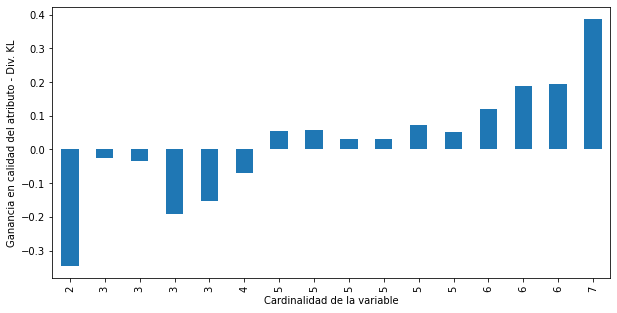

In [ ]:
plt.figure(figsize=(10, 5))
ax = pd.Series(np.mean(divergencia_kl_igual_budget, axis=0) - np.mean(divergencia_kl_budget_cat, axis=0), index=cardinalidad).sort_index().plot.bar()
ax.set_ylabel('Ganancia en calidad del atributo - Div. KL')
ax.set_xlabel('Cardinalidad de la variable')


Esta apertura de la mejora en la calidad de la información (medida a través de la divergencia KL), muestra exactamente los resultados que esperábamos: las variables de mayor cardinalidad resultaron beneficiadas, mientras que las de menor cardinalidad perdieron calidad. Esta reasignación del presupuesto trajo aparejada una mejora en la calidad global de la información. 

## 2.2.4 Calibrando el budget

##### Hasta ahora veníamos trabajando en todas las simulaciones con un budget fijo. Si bien el valor utilizado aparece como un valor razonable, resta analizar en profundidad cuál es la mejor medida de budget a utilizar.

##### Aunque la determinación del budget es en última instancia una 'decisión de negocio', y varía en función de los requerimientos de privacidad que el owner del producto busca, vale la pena hacer un análisis de sensibilidad entre distintos budgets y la calidad de información de la salida, para ayudar a la toma de esta decisión.

##### Antes de continuar debemos traer de la teoría el concepto de composición avanzada. Hasta el momento, las simulaciones que hicimos se basarón en el teorema de la composición simple. Bajo este precepto, el presupuesto total de un conjunto de queries correlacionadas es la suma de todos los presupuestos individuales. No obstante, introduciendo una relajación de la definición de DP (que veremos que aparece en el código como  'slack'), podemos hacer uso del teorema de la composición avanzada.

##### Para una mayor exposición sobre el concepto de composición avanzada y la relajación de la garantía DP, sugerimos que se revise la sección de teoría de la tesis. Por ahora lo importante es señalar que el principio de composición avanzada permite computar el presupuesto no como una función lineal de la cantidad de consultas $k$ , sino como una función de $\sqrt{k}$ .





##### Habiendo hecho esta primera introducción a la dinámica de la composición avanzada, vamos a realizar a continuación un análisis de sensibilidad de la calidad de la información (medida a través de la divergencia KL y el error absoluto) en función del budget, computado tanto como composición simple y como cumpuesta. 

In [ ]:
budgets = [0.5,1,2,3,4,5,6,7,8, 9,10]
categorias = 0
for (columnName, columnData) in ds.iteritems():
  categorias+=len(columnData.unique())### Preciso saber de antemano el número de bins que hay.
error = []

delta = 0.0005
sens = np.sqrt(len(ds.columns))

for b in budgets:
  budget = b
  epsilon_x_categoria = budget/categorias ### Estimo el budget que se asignará a cada categoria
  divergencia_kl_budget_cat = []
  error_absoluto_budget_cat = []
  for i in range(0,100):
    div_kl_hist = []
    error_abs_hist = []

    acc = dp.BudgetAccountant(slack=0.005)
    for (columnName, columnData) in ds.iteritems():
      
      
      codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
      n_cat = len(np.unique(codes))###Calculo la cantidad de bins que tendrá el histograma, que será uno por categoría de la variable.
      epsilon = n_cat*epsilon_x_categoria###A cada feature le asigno el budget proporcional a la cantidad de bin´s

      ###CON DP
      dp_hist, dp_bins = dp.tools.histogram(codes, mech='gauss', delta=delta, epsilon=epsilon ,sens=sens, bins=n_cat, accountant=acc)

      ###Sin DP
      hist, bins = np.histogram(codes, bins=n_cat)
      hist = hist / hist.sum()

      ###Error
      div_kl_hist.append(kl(hist, dp_hist))
      error_abs_hist.append(np.abs(hist - dp_hist).sum())

    divergencia_kl_budget_cat.append(div_kl_hist)
    error_absoluto_budget_cat.append(error_abs_hist)

  divergencia_kl_budget_cat = np.mean(divergencia_kl_budget_cat, axis=0)
  error_absoluto_budget_cat = np.mean(error_absoluto_budget_cat, axis=0)

  error.append([b, acc.total()[0], acc.total()[1],np.mean(divergencia_kl_budget_cat), np.mean(error_absoluto_budget_cat)])
  

In [ ]:
resultados = pd.DataFrame(error)
resultados.columns = ['Budget composición simple', 'Budget composición avanzada', 'Delta','Divergencia KL', 'Error absoluto']

In [ ]:
resultados

,Budget composición simple,Budget composición avanzada,Delta,Divergencia KL,Error absoluto
0,0.5,0.346850,0.01293,4.520660,0.954201
1,1.0,0.772783,0.01293,2.816770,0.716117
2,2.0,1.731923,0.01293,1.102445,0.424736
3,3.0,2.798768,0.01293,0.560290,0.300250
4,4.0,3.939388,0.01293,0.398058,0.239840
5,5.0,5.000000,0.01293,0.258123,0.198215
6,6.0,6.000000,0.01293,0.178785,0.171723
7,7.0,7.000000,0.01293,0.143408,0.145950
8,8.0,8.000000,0.01293,0.107792,0.128863
9,9.0,9.000000,0.01293,0.087129,0.118301


A pesar de las ventajas teóricas de la composición avanzada, vemos que no implica ventajas para nuestro caso. De hecho, la mejora en el budget total se verifica cuando el $\epsilon$ asignado a cada consulta es muy bajo, lo que no es nuestro caso. Asimismo, no debemos perder de vista que estas estimaciones incluyen un slack muy alto, con lo que el $\delta$ total es superior al 1,2% (muy superior a valores recomendables). Por ello, seguiremos computando el budget a través de la composición simple.

Analicemos a continuación con mayor detalle cómo evoluciona el error en función del budget, pero ya únicamente a través de la composición simple.

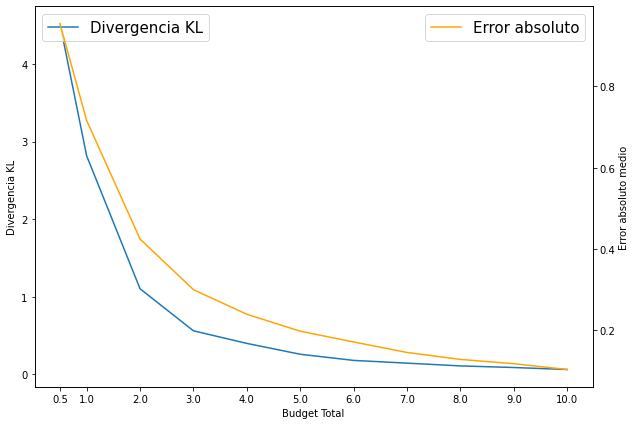

In [ ]:
fig, ax = plt.subplots(figsize = (10, 7))

ax.plot(resultados['Budget composición simple'], resultados['Divergencia KL'])
ax2 = ax.twinx()

ax2.plot(resultados['Budget composición simple'], resultados['Error absoluto'], color='orange')

ax.set_xticks(resultados['Budget composición simple'])
ax.set_xticklabels(resultados['Budget composición simple'])
ax.set_xlabel('Budget Total')
ax.set_ylabel('Divergencia KL')
### ax.set_title('Error del mecanismo DP en función del budget asignado', size = 25)

ax2.set_ylabel('Error absoluto medio')

ax.legend(['Divergencia KL'], fontsize = 15, loc = 2)
ax2.legend(['Error absoluto'], fontsize = 15, loc = 1)


El error parece tener una caída muy fuerte entre los 2 y 4 epsilons de budget, luego de lo cual sigue descendiendo, pero a un ritmo mucho más lento. La utilización de un budget de 4 epsilon aparece como un valor que permite equilibrar la calidad de la información con una garantía de privacidad no completamente rígida (epsilons menores a 1 ofrecen garantías de privacidad muy elevados), pero aceptable. Veamos ahora utilizando composición simple cual fue el delta alcanzado.

In [ ]:
acc = dp.BudgetAccountant()
for i in ds.columns:
  acc.spend(4/len(ds.columns), 0.0005)
acc.total()


(epsilon=4.0, delta=0.007970069886386376)

El $\delta$ total compuesto parece ser mayor a lo recomendable (1/Cantidad de individuos en el dataset), pero así y todo se ubica en un nivel tolerable. 

A pesar de que las garantías de privacidad que aceptamos no se hallan dentro de las más estrictas las consideramos útiles por varios motivos. Primero, si se incrementan la calidad de la información decae muy rápidamente. Segundo, aún a pesar de la laxitud, representan una gran mejoría respecto a las técnicas utilizadas en la actualidad. Tercero, se espera en el futuro, en base a los resultados de este trabajo, poder encontrar estrategias superadoras, que alcancen garantías de privacidad más rígidas. No obstante, el principal motivo por el cual aceptamos estos umbrales de privacidad radica en que presumimos que los individuos no tienen expectativas de privacidad estricta. Desde el momento que las sentencias son públicas, toda esta información (o parte) puede reconstruirse a partir de las sentencias publicadas por los juzgados. Entonces, consideramos satisfactorio un nivel de privacidad probablemente no recomendable en otros casos. La realidad es que nuestro objetivo es ofrecer una MEJORA en en nivel de privacidad de los individuos involucrados en las causas, no una garantía estricta (ya que ello nunca será posible dado el caracter público de las sentencias).

## 2.2.5 Sensibilidad del error al tamaño del dataset

Aunque no es algo que podamos controlar, ya que el conjunto de datos nos viene dado (y no se puede realizar data augmentation ya que ello introduce riesgos a las garantías de DP), debemos tener una noción de cómo el tamaño del dataset influye en la calidad de la información. Ello nos servirá para poder determinar mejores estrategias de cara a futuras mejoras.

In [ ]:
error = []

for n_reg in range(100, 2050, 50):
  ds_boots = ds.sample(n=n_reg, replace=True)

  categorias = 0
  for (columnName, columnData) in ds_boots.iteritems():
    categorias+=len(columnData.unique())### Preciso saber de antemano el número de bins que hay.

  delta = 0.0005
  sens = np.sqrt(len(ds_boots.columns))
  epsilon_x_categoria = 4/categorias ### Estimo el budget que se asignará a cada categoria
  divergencia_kl_budget_cat = []
  error_absoluto_budget_cat = []
  for i in range(0,100):
    div_kl_hist = []
    error_abs_hist = []

    ###acc = dp.BudgetAccountant(slack=0.005)
    for (columnName, columnData) in ds_boots.iteritems():
      
      
      codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
      n_cat = len(np.unique(codes))###Calculo la cantidad de bins que tendrá el histograma, que será uno por categoría de la variable.
      epsilon = n_cat*epsilon_x_categoria###A cada feature le asigno el budget proporcional a la cantidad de bin´s

      ###CON DP
      dp_hist, dp_bins = dp.tools.histogram(codes, mech='gauss', delta=delta, epsilon=epsilon ,sens=sens, bins=n_cat)

      ###Sin DP
      hist, bins = np.histogram(codes, bins=n_cat)
      hist = hist / hist.sum()

      ###Error
      div_kl_hist.append(kl(hist, dp_hist))
      error_abs_hist.append(np.abs(hist - dp_hist).sum())

    divergencia_kl_budget_cat.append(div_kl_hist)
    error_absoluto_budget_cat.append(error_abs_hist)

  divergencia_kl_budget_cat = np.mean(divergencia_kl_budget_cat, axis=0)
  error_absoluto_budget_cat = np.mean(error_absoluto_budget_cat, axis=0)

  error.append([n_reg, np.mean(divergencia_kl_budget_cat), np.mean(error_absoluto_budget_cat)])

In [ ]:
error = pd.DataFrame(error)
error.columns = ['Tamaño del dataset', 'Divergencia KL', 'Error absoluto']
error

,Tamaño del dataset,Divergencia KL,Error absoluto
0,100,4.299009,0.885155
1,150,3.591218,0.820205
2,200,2.616989,0.683275
3,250,2.090992,0.585316
4,300,1.611382,0.505399
5,350,1.398990,0.468547
6,400,0.986552,0.408383
7,450,0.864896,0.376305
8,500,0.743285,0.346901
9,550,0.646302,0.325689


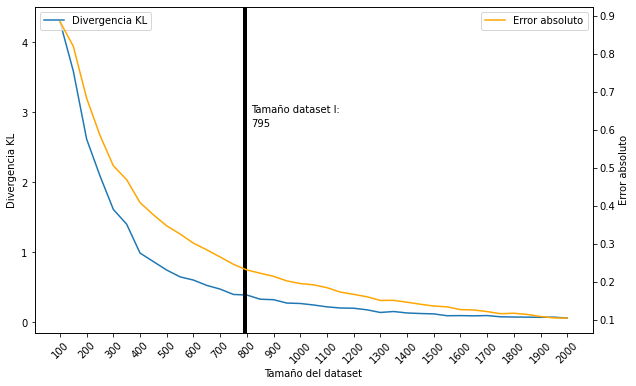

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(error['Tamaño del dataset'], error['Divergencia KL'])

ax2 = ax.twinx()

ax2.plot(error['Tamaño del dataset'], error['Error absoluto'], color='orange')

ax.axvline(x=len(ds), linewidth=4, color='black')
ax.text(len(ds)+20, 3, 'Tamaño dataset I:')
ax.text(len(ds)+20, 2.8, str(len(ds)))

ax.set_xticks([x for x in error['Tamaño del dataset'] if x%100 == 0])
ax.set_xticklabels([x for x in error['Tamaño del dataset'] if x%100 == 0], rotation='45', size = 10)
ax.set_xlabel('Tamaño del dataset')
ax.set_ylabel('Divergencia KL')
###ax.set_title('Error del mecanismo DP en función del tamaño del dataset', size = 25)

ax2.set_ylabel('Error absoluto')

ax.legend(['Divergencia KL'], loc = 2)
ax2.legend(['Error absoluto'], loc = 1)



Tal como sugiere la literatura, el tamaño del dataset tiene un impacto marcado en la calidad de la salida. Esto se debe a que el ruido a adicionar se determina en función del budget y de la sensibilidad de la consulta, pero no guarda relación alguna con el tamaño del dataset. Así, el ruido es de una magnitud fija. Recordemos que un mecanismo de DP básicamente lo que esta haciendo es computar el resultado de una función y adicionarle una cantidad fija de ruido. Si el dataset es pequeño, lo que pasa es que en términos relativos el ruido agregado es muy importante. A medida que escala, el ruido, que permanece en una magnitud fija, pierde relevancia. Por ello, los mecanismos de DP son muy sensibles al tamaño del dataset y se recomienda trabajar con grandes volúmenes de datos.

En relación a nuestro dataset vemos que es muy pequeño para la cantidad de consultas que estamos realizando. Bien podrían tratar de disminuirse las mismas, aunque recordemos que el ruido solo disminuiría en función de $\sqrt{k}$, con lo cual la ganancia es limitada. Para este caso, la recomendación es incrementar el tamaño del dataset, al menos duplicándolo.

## 2.2.6 Conclusiones del apartado



*   En base al conjunto de datos disponible, es posible aplicar un mecanismo de DP que permita liberar información útil, garantizando niveles aceptables de privacidad
*   Una vez aplicada la ingeniería de atributos propuesta en el notebook 2.1, hemos encontrado un óptimo utilizando el mecanismo gaussiano con un budget de 4 $\epsilon$ y $\delta$ de 0.0005 por consulta.
*   Se recomienda duplicar al menos el tamaño del conjunto de datos, para disminuir el impacto del ruido incorporado por los mecanismos de DP, más teniendo en cuenta otros posibles desarrollos posteriores, como la publicación de tablas de contingencia (que requieren la incorporación de cantidades de ruido muy superiores).




